<a href="https://colab.research.google.com/github/EauDeData/EauDeData.github.io/blob/master/docencia/MPiHD/practica_fotografia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pràctica Processat de Fotografía
## Métodes de visió per computador en el contexte de la imatge de la fotografia histórica

Per poder visualitzar tots els continguts interactius de l'exercici, premeu el botó "play" a l'esquerra de cada cel·la en ordre. 

Qualsevol dubte podeu escriure amolina@cvc.uab.cat

Intenteu donar resposta a cadascuna de les questions de forma detallada i fent referència tant al material exposat com a part teórica com al material del propi exercici.

In [23]:
#@title
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils import contours
import random
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import scipy.ndimage as ndim

In [21]:
#@title
!mkdir content
!curl https://eaudedata.github.io/docencia/MPiHD/contingut/imatges/horses.jpg -o content/horses.jpg
!curl https://tile.loc.gov/storage-services/master/pnp/prok/01000/01047u.tif -o content/master-pnp-prok-01000-01047u.tif

mkdir: cannot create directory ‘content’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34602  100 34602    0     0   293k      0 --:--:-- --:--:-- --:--:--  293k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34.4M  100 34.4M    0     0   125M      0 --:--:-- --:--:-- --:--:--  125M


In [4]:
#@title

def imread(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)
def visualize_image(img):
    
    if len(img) == 2:
        
        fig, axs = plt.subplots(1, 2, figsize = (16, 32))
        axs[0].imshow(img[0], cmap = 'gray')
        axs[0].axis('off')
        
        axs[1].imshow(img[1], cmap = 'gray')
        axs[1].axis('off')
        
        plt.box(on=None)
        plt.show()
        
        return None
    
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    plt.box(on=None)
    plt.show()
    


## Eines per detecció d'objectes

#### Objectiu: Concatena operacions sobre la següent imatges per tant de poder localitzar els diferents objectes de l'escena. Respon les preguntes i raona l'efectivitat de la teva decisió en quant els valors i operacions escollits.
<img src="https://eaudedata.github.io/docencia/MPiHD/contingut/imatges/horses.jpg">


>

In [5]:
#@title
THR_VALUE = 75
MIN_SIZE = 100
SOBEL_SIZE = 5
def threshold(img):
    global THR_VALUE
    return cv2.threshold(img, THR_VALUE, 255, cv2.THRESH_BINARY_INV)[1]

def contours_sobel(img):
    
    scale = 1
    delta = 0
    
    grad_x = cv2.Sobel(img, -1, 1, 0, ksize=SOBEL_SIZE, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    # Gradient-Y
    # grad_y = cv.Scharr(gray,ddepth,0,1)
    grad_y = cv2.Sobel(img, -1, 0, 1, ksize=SOBEL_SIZE, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    
    
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    
    
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    
    return grad

def avg_blur(img):
    kernel = np.ones((5,5),np.float32)/25
    return cv2.filter2D(img,-1,kernel)

def detect(image, pipeline = []):
    
    global MIN_SIZE
    
    base = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
    
    for f in pipeline:
        image = f(image)
    
    cnts, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not len(cnts): return base, image
    for n, c in enumerate(cnts):
        if hierarchy[0][n][-1] != -1: continue
        x,y,w,h = cv2.boundingRect(c)
        if w*h < MIN_SIZE: continue
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.rectangle(base, (x, y), (x + w, y + h), color, 5)
    return base, image

In [6]:
#@title
inim = imread('content/horses.jpg')

In [7]:
#@title
thr = widgets.IntSlider(
    value=0,
    min=0,
    max=255,
    step=1,
    description='Threshold Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

size = widgets.IntSlider(
    value=1,
    min=1,
    max=500,
    step=1,
    description='Min Size Detected:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

sobel_size = widgets.IntSlider(
    value=1,
    min=1,
    max=30,
    step=1,
    description= 'Sobel Size:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

pos1 = widgets.ToggleButtons(
    options=['threshold', 'average blur', 'sobel', 'None'],
    description='Operation #1:',
    disabled=False,
    button_style='',
)

pos2 = widgets.ToggleButtons(
    options=['threshold', 'average blur', 'sobel', 'None'],
    description='Operation #2:',
    disabled=False,
    button_style='',
)

pos3 = widgets.ToggleButtons(
    options=['threshold', 'average blur', 'sobel', 'None'],
    description='Operation #3:',
    disabled=False,
    button_style='',
)

button = widgets.Button(description="Llença Experiment")
output = widgets.Output()


def selector2function(string):
    if string == 'threshold': return threshold
    if string == 'average blur': return avg_blur
    if string == 'sobel': return contours_sobel
    return lambda x: x
    

def button_click(b):
    
    with output:
        clear_output()
        pipeline = [selector2function(x.value) for x in [pos1, pos2, pos3]]
        global THR_VALUE 
        THR_VALUE= thr.value
        global MIN_SIZE 
        MIN_SIZE = size.value
        global SOBEL_SIZE 
        SOBEL_SIZE = sobel_size.value
        if SOBEL_SIZE %2 == 0: SOBEL_SIZE += 1

        base, im = detect(inim, pipeline=pipeline)
        visualize_image([base, im])
    return None

print("Hyperparameters:\n")
display(thr, size, sobel_size)
print("\nFirst Operation:")
display(pos1)
display(pos2)
display(pos3)
print("\n")
display(button, output)
button_click(button)
button.on_click(button_click)


Hyperparameters:



IntSlider(value=0, continuous_update=False, description='Threshold Range:', max=255)

IntSlider(value=1, continuous_update=False, description='Min Size Detected:', max=500, min=1)

IntSlider(value=1, continuous_update=False, description='Sobel Size:', max=30, min=1)


First Operation:


ToggleButtons(description='Operation #1:', options=('threshold', 'average blur', 'sobel', 'None'), value='thre…

ToggleButtons(description='Operation #2:', options=('threshold', 'average blur', 'sobel', 'None'), value='thre…

ToggleButtons(description='Operation #3:', options=('threshold', 'average blur', 'sobel', 'None'), value='thre…

Button(description='Llença Experiment', style=ButtonStyle())

Output()

### Preguntes:

- Quina és la 'pipeline' (operacions a fer) i la combinació de paràmetres més òptima?

- Què pasa si fem un numero parell de "thresholds"? Per què?

- Quin efecte té el paràmetre "sobel size"?

## Detecció de punts clau
Objectiu: Durant els segles XIX i XX el fotógraf rus Sergey Mikhaylovich va produir una sèrie de fotografies aparentment sencilles, però amb una particularitat:
Sobre un mateix camp visual, es fotografiava amb un filtre vermell (*R*ed), verd (*G*reen) i blau (*B*lue).

In [8]:
#@title
img = imread('content/master-pnp-prok-01000-01047u.tif')

In [25]:
#@title
B = (img[:3218, :]) / 255
G = (img[3219:3219*2-1, :]) / 255
R = (img[3219*2:(3219*3), :]) / 255

Les diferents imatges, en ser monocromatiques es veuen de la següent manera. Tinguem en consideració que aquesta escala de grisos no s'asigna a tot l'espectre visible com estem acostumats, sino únicament a una part.

### Preguntes:

* A quina part de l'espectre visible fa referència aquesta escala de grisos?
* Com obtindries aquestes tres imatges amb una càmera que transformi tot l'espectre visible en una escala de grisos? 

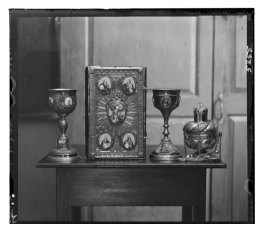

In [24]:
#@title
visualize_image(B)

Nogensmenys les imatges no estan perectament alineades, superposarles asumint que les capes estan colocades com corresponen provoca el següent:

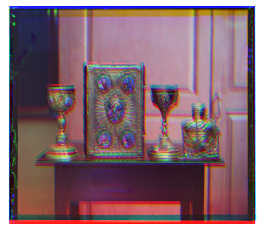

In [11]:
#@title
plt.imshow(np.stack([R, G, B]).transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [15]:
#@title
def sobel(img):
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    return sobelx + sobely

def normalize(img):
    tmp = img - img.min()
    tmp = tmp / tmp.max()
    return tmp


def mat_max(img):
    return np.unravel_index(img.argmax(), img.shape)

def uint8(img):
  return img.astype(np.uint8)

In [16]:
#@title
def match_template(red, green, blue): #EXTRA 2
    gs = sobel(green)
    rs = sobel(red)
    bs = sobel(blue)
    w, h = green.shape
    size = w//8 #o 6
    tl_template = (w//2 - size, h//2 - size)
    template = uint8(gs[w//2 - size:w//2 + size, h//2 - size:h//2 + size])
    red_shift = cv2.matchTemplate(uint8(rs), template, cv2.TM_CCOEFF)
    _, _, _, tl_red = cv2.minMaxLoc(red_shift)
    blue_shift = cv2.matchTemplate(uint8(bs), template, cv2.TM_CCOEFF)
    _, _, _, tl_blue = cv2.minMaxLoc(blue_shift)
    r_shift = (-(tl_red[1] - tl_template[0]), -(tl_red[0] - tl_template[1]))
    b_shift = (-(tl_blue[1] - tl_template[0]), -(tl_blue[0] - tl_template[1]))
    new_red = normalize(ndim.shift(red, r_shift))
    new_blue = normalize(ndim.shift(blue, b_shift))
    new_color = np.array([new_red, green, new_blue]).transpose((1, 2, 0))
    return new_color, red_shift, blue_shift, template

In [22]:
#@title

result, rs, bs, template = match_template(R, G, B)

In [18]:
#@title
rs = (normalize(rs) * 255).astype(np.uint8)
bs = (normalize(bs) * 255).astype(np.uint8)


hq_rs = cv2.equalizeHist(rs)
hq_bs = cv2.equalizeHist(bs)

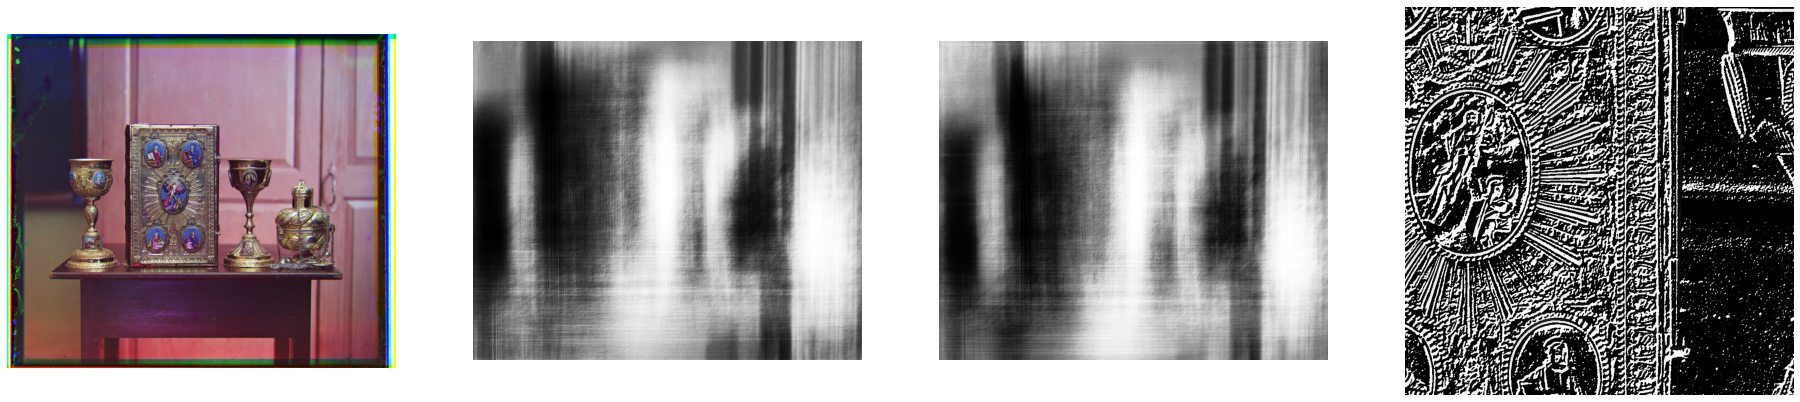

In [19]:
#@title
fig, axs = plt.subplots(1, 4, figsize = (32, 8))
def fill_ax(ax, img):
    if img.shape[-1] == 3:
        ax.imshow(img)
    else:
        ax.imshow(img, cmap = 'gray')
    ax.axis('off')
    

fill_ax(axs[0], result)
fill_ax(axs[1], hq_rs)
fill_ax(axs[2], hq_bs)
fill_ax(axs[3], template)
plt.show()

### Preguntes: 

* Aprofitant la informació a la dreta del resultat, quin procès (concatenació d'operacions) creus que s'ha utilitzat per generar la imatge en color? 
* Quines altres maneres trobes de fer-ho?
* Qué representa la última imatge (dreta)?
